# Second phase notebook: Recommending Rental Properties / Case: Boston
This notebook includes 10 parts:
1. downloading the neighbourhoods' report
2. importing, cleaning and forming the dataset
3. finding the coordinates of neighbourhoods
4. plotting location of neighbourhoods
5. filtering neighbourhoods by distance
6. finding venues in the selected neighbourhoods
7. analysing each neighbourhood by found venues
8. developing scoring frame and ranking neighbourhoods
9. finding, filtering, and plotting rental properties
10. clustring and visualisation of results
each steps is explianed later. This notebook is published on **github** and for veiwing plots **nbviewer** should be used.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
from dotenv import load_dotenv
from pathlib import Path
import os, tabula, wget, requests, subprocess, warnings
# disabling warnings 
warnings.filterwarnings("ignore")

## 1st step, downloading the neighbourhoods' report
in this step the dataset is downloaded using wget which is utilised with subprocess library. The downloaded file is saved in the main directory. The important point is two datasets have been used in this project, the first one belongs to Boston, and the second one belongs to Cambridge.

In [2]:
# importing dataset
# dataset 1
url = r'http://www.bostonplans.org/getattachment/6f48c617-cf23-4c9f-b54b-35c8a954091c'
file_name_1 = r'boston_statistics.pdf'
path = os.path.dirname(os.path.abspath('Recommending rental properties.ipynb'))
subprocess.run(["wget", "-r", "-nd", "-O", file_name_1, path, url])
# dataset 2
url = r'https://www.cambridgema.gov/CDD/externallinks/Profiles/neighborhoodprofile'
file_name_2 = r'cambridge_statistics.pdf'
subprocess.run(["wget", "-r", "-nd", "-O", file_name_2, path, url])

CompletedProcess(args=['wget', '-r', '-nd', '-O', 'cambridge_statistics.pdf', 'C:\\Users\\King Aron\\Desktop\\Python_projects\\Coursera_Capstone\\Boston Neighbourhoods', 'https://www.cambridgema.gov/CDD/externallinks/Profiles/neighborhoodprofile'], returncode=4)

## 2nd step, importing, cleaning and forming the dataset
The downloaded pdf file has many pages including demographic data. Page 5 includes age distribtion of Boston City and becasue it might be useful if later analysis this page has been used. The pdf file is read by use of tabula library. In the next step, desired columns are selected and the data is coverted into float type.

In [3]:
# cleaning and forming the dataset 1
df_1 = tabula.read_pdf(file_name_1, pages = 5)[0]
df_1.drop([0,1,2], inplace = True, axis = 0) # the first three rows are irrelevent
columns_list = list(range(0,3,1)) + list(range(3,15,2))
df_1 = df_1[df_1.columns[columns_list]] # Aron is interested in young neighbourhoods
df_1.columns = ['neighbourhood', 'total_population', 'median_age', '0-9', '10-19', '20-34', '35-54', '55-64', '65+']
df_1.reset_index(inplace = True, drop = True)
# coversion of types
def replace_resi(col):
    for ii in range(0, len(col)):
        col[ii] = col[ii].replace(',', '')
    return col
col_list = [1] + list(range(3,len(df_1.columns)))
df_1.iloc[:,col_list] = df_1.iloc[:,col_list].apply(replace_resi, axis=0)
df_1.iloc[:,1:] = df_1.iloc[:,1:].astype('float')
# brief insights 1
print('There are {:.0f} neighbourhoods in Boston \n'.format(df_1['neighbourhood'].count()))
print('Boston total population is {:.0f} \n'.format(df_1['total_population'].sum()))
print('{:.2f}% of this population aged between 20-34 \n'.format(df_1['20-34'].sum() / df_1['total_population'].sum() * 100))
df_1

Got stderr: Aug 23, 2020 9:18:31 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font ABCDEE+Calibri are not implemented in PDFBox and will be ignored
Aug 23, 2020 9:18:31 PM org.apache.pdfbox.pdmodel.font.PDCIDFontType2 <init>
INFO: OpenType Layout tables used in font ABCDEE+Calibri-Bold are not implemented in PDFBox and will be ignored



There are 23 neighbourhoods in Boston 

Boston total population is 650281 

34.68% of this population aged between 20-34 



,neighbourhood,total_population,median_age,0-9,10-19,20-34,35-54,55-64,65+
0,Allston,19761.0,27.0,644.0,3152.0,12741.0,1912.0,691.0,621.0
1,Back Bay,17577.0,33.0,756.0,1372.0,7681.0,3229.0,1973.0,2566.0
2,Beacon Hill,9305.0,31.0,686.0,247.0,4909.0,1751.0,646.0,1066.0
3,Brighton,47768.0,31.0,2852.0,3016.0,25485.0,7238.0,3577.0,5600.0
4,Charlestown,18058.0,34.0,2559.0,1256.0,5754.0,4774.0,2006.0,1709.0
5,Dorchester,124489.0,33.0,15841.0,16428.0,33342.0,33529.0,13470.0,11879.0
6,Downtown,16903.0,34.0,888.0,2440.0,5647.0,3303.0,2067.0,2558.0
7,East Boston,44989.0,34.0,5778.0,4237.0,13361.0,13917.0,3745.0,3951.0
8,Fenway,32210.0,23.0,452.0,8582.0,17575.0,2883.0,1271.0,1447.0
9,Harbor Islands,329.0,42.0,0.0,5.0,127.0,94.0,70.0,33.0


In [4]:
# cleaning and forming the dataset 2
df_2 = tabula.read_pdf(file_name_2, pages = 65)[1]
df_2.columns = ['neighbourhood / area', 'pop_2000', 'pop_2010', 'pop_2013-2017', '2000_%', '2010_%', '2013-17_%', 'net', '%']
df_2['neighbourhood'] = ""
for ii, ob in enumerate(df_2['neighbourhood / area']):
    n_ob = ob.find(' /')
    if n_ob == -1:
        df_2['neighbourhood'].iloc[ii] = ob
    else:
        df_2['neighbourhood'].iloc[ii] = ob[:n_ob]
col_list = range(1, 4)
df_2.iloc[:,col_list] = df_2.iloc[:,col_list].apply(replace_resi, axis=0)
df_2.iloc[:,col_list] = df_2.iloc[:,col_list].astype('float')
# brief insights 2
print('There are {:.0f} neighbourhoods in Cambridge \n'.format(df_2['neighbourhood'].count()))
print('Cambrdige total population is {:.0f} \n'.format(df_2['pop_2013-2017'].sum()))
df_2

There are 13 neighbourhoods in Cambridge 

Cambrdige total population is 110893 



,neighbourhood / area,pop_2000,pop_2010,pop_2013-2017,2000_%,2010_%,2013-17_%,net,%,neighbourhood
0,East Cambridge / Area 1,7294,9234,10336,7.2%,8.8%,9.3%,"3,042",41.7%,East Cambridge
1,MIT / Area 2,5486,5057,4859,5.4%,4.8%,4.4%,-627,-11.4%,MIT
2,Wellington-Harrington / Area 3,7345,6516,6576,7.2%,6.2%,5.9%,-769,-10.5%,Wellington-Harrington
3,The Port / Area 4,7263,6792,7053,7.2%,6.5%,6.4%,-210,-2.9%,The Port
4,Cambridgeport / Area 5,10052,12220,12621,9.9%,11.6%,11.4%,"2,569",25.6%,Cambridgeport
5,Mid-Cambridge / Area 6,13589,12991,13438,13.4%,12.4%,12.1%,-151,-1.1%,Mid-Cambridge
6,Riverside / Area 7,10897,12695,12361,10.8%,12.1%,11.1%,"1,464",13.4%,Riverside
7,Agassiz / Area 8,5241,4977,5382,5.2%,4.7%,4.9%,141,2.7%,Agassiz
8,Neighborhood Nine,11794,11399,12034,11.6%,10.8%,10.9%,240,2.0%,Neighborhood Nine
9,West Cambridge / Area 10,8149,8023,8603,8.0%,7.6%,7.8%,454,5.6%,West Cambridge


In [5]:
# Joining two datasets into a new dataset
df = list(df_1['neighbourhood']) + list(df_2['neighbourhood'])
df = pd.DataFrame(df)
df.columns = ['neighbourhood']
df

,neighbourhood
0,Allston
1,Back Bay
2,Beacon Hill
3,Brighton
4,Charlestown
5,Dorchester
6,Downtown
7,East Boston
8,Fenway
9,Harbor Islands


## 3rd step, finding coordinates
In this section, geocoder is used in a loop to find correspnding long/lat of each rows. Important parts are as follows:
1. using geopy, Nominatim
2. passing GeocoderTimedOut for avoiding errors of timing out
3. setting a search limit for a neighbourhood
4. using sleep of 1 sec for avoiding server runtime limit block
5. passing a random symbolic password
6. random ordering of address 
<br>

Finally, becasue some neighbourhoods' coordinates not found, they are handeled manually.

In [6]:
import geopy, random
from time import sleep
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [7]:
def do_geocode(address):
    geopy = Nominatim(user_agent="aron.shirazi@gmail.com")
    try:
        sleep(1)
        return geopy.geocode(address)
    except GeocoderTimedOut:
        return do_geocode(address)

df['latitude'] = 'NA'
df['longitude'] = 'NA'
max_try = 10
for nn in range(0, len(df)):
    neighbourhood = df['neighbourhood'].iloc[nn]
    location = None
    count = 0
    while (location == None) & (count < max_try):
        password = ''.join(random.choice(['#', '$', '%', '@', '*', '-', '&', '~', '!']) for i in range(8))
        address_list = [neighbourhood, 'Boston', 'Massachusetts', password]
        order = ''.join(random.sample(['0', '1', '2', '3'], 4))
        n0 = int(order[0]); n1 = int(order[1]); n2 = int(order[2]); n3 = int(order[3])
        address = '{}, {}, {}, {}'.format(address_list[n0], address_list[n1], address_list[n2], address_list[n3])
        location = do_geocode(address)
        count += 1
    if location is not None:
        print('{}, coordinates found for {}'.format(nn, neighbourhood))
        df['latitude'].iloc[nn] = location.latitude
        df['longitude'].iloc[nn] = location.longitude
    else:
        print('{}, coordinates not found for {}'.format(nn, neighbourhood))
df

0, coordinates found for Allston
1, coordinates found for Back Bay
2, coordinates found for Beacon Hill
3, coordinates found for Brighton
4, coordinates found for Charlestown
5, coordinates found for Dorchester
6, coordinates found for Downtown
7, coordinates found for East Boston
8, coordinates found for Fenway
9, coordinates found for Harbor Islands
10, coordinates found for Hyde Park
11, coordinates found for Jamaica Plain
12, coordinates found for Longwood
13, coordinates found for Mattapan
14, coordinates found for Mission Hill
15, coordinates found for North End
16, coordinates found for Roslindale
17, coordinates found for Roxbury
18, coordinates found for South Boston
19, coordinates found for South Boston Waterfront
20, coordinates found for South End
21, coordinates found for West End
22, coordinates found for West Roxbury
23, coordinates found for East Cambridge
24, coordinates found for MIT
25, coordinates not found for Wellington-Harrington
26, coordinates found for The Po

,neighbourhood,latitude,longitude
0,Allston,42.3554,-71.1321
1,Back Bay,42.3503,-71.1012
2,Beacon Hill,42.3587,-71.0678
3,Brighton,42.3501,-71.1564
4,Charlestown,42.3779,-71.062
5,Dorchester,42.3329,-71.0448
6,Downtown,42.355,-71.0661
7,East Boston,42.3751,-71.0392
8,Fenway,42.3452,-71.1046
9,Harbor Islands,42.2697,-70.9209


In [12]:
# insterting coordinates of some neighbourhoods
df['latitude'].iloc[25] = 42.3713
df['longitude'].iloc[25] = -71.0929
df['latitude'].iloc[28] = 42.3724
df['longitude'].iloc[28] = -71.1062
df['latitude'].iloc[34] = 42.3890
df['longitude'].iloc[34] = -71.1478

## 4th step, plotting locations
in this step, found coordinates of neighbourhoods are plotted along with their attached names. The initial zoom command in folium is not used, instead a more efficient method of fit_bound has been utilised.

In [13]:
# importing the library
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
# finding the center of map for illustration purpuse
df_loc = df[['neighbourhood', 'latitude', 'longitude']]
center_lat = df_loc['latitude'].mean()
center_lon = df_loc['longitude'].mean()
# to set boundaries of folium
lat_min = df_loc['latitude'].min()
lat_max = df_loc['latitude'].max()
lon_min = df_loc['longitude'].min()
lon_max = df_loc['longitude'].max()

In [15]:
map_boston = folium.Map(location=[center_lat, center_lon], width=800, height=600)
map_boston.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])
# add markers to map
for lat, lng, label in zip(df_loc['latitude'], df_loc['longitude'], df_loc['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
map_boston

# 5th step, filtering neighbourhoods by distance
Aron has decided to find an apratment as close as possible to the campus. His ideal choice would be less than 3 km from the MIT campus. The selected neighbourhoods are filtered by the calculated distances.

In [16]:
from geopy.distance import geodesic 
campus_loc = (42.3601, -71.0942)
df['distance'] = np.nan
for ii in range(0,len(df)):
    test_loc = (df['latitude'][ii], df['longitude'][ii])
    df['distance'].iloc[ii] = geodesic(campus_loc, test_loc).km
desired_distance = 3 #km
df_select = df[df['distance'] <= desired_distance]
df_select

,neighbourhood,latitude,longitude,distance
1,Back Bay,42.3503,-71.1012,1.231210
2,Beacon Hill,42.3587,-71.0678,2.178011
6,Downtown,42.355,-71.0661,2.386151
8,Fenway,42.3452,-71.1046,1.865004
12,Longwood,42.3371,-71.1019,2.631950
20,South End,42.3413,-71.0843,2.238435
21,West End,42.3603,-71.0583,2.958284
23,East Cambridge,42.3514,-71.0898,1.032944
24,MIT,42.3545,-71.0913,0.661403
25,Wellington-Harrington,42.3713,-71.0929,1.248701


In [18]:
# finding the center of map for illustration purpuse
df_loc = df_select[['neighbourhood', 'latitude', 'longitude']]
center_lat = df_loc['latitude'].mean()
center_lon = df_loc['longitude'].mean()
# to set boundaries of folium
lat_min = df_loc['latitude'].min()
lat_max = df_loc['latitude'].max()
lon_min = df_loc['longitude'].min()
lon_max = df_loc['longitude'].max()
map_boston = folium.Map(location=[center_lat, center_lon], width=800, height=600)
map_boston.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])
# add markers to map
for lat, lng, label in zip(df_loc['latitude'], df_loc['longitude'], df_loc['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)
label = folium.Popup('Campus', parse_html=True)
folium.CircleMarker(
    campus_loc,
    radius=10,
    popup=label,
    color='red',
    fill=True,
    fill_color='#cc4331',
    fill_opacity=0.7,
    parse_html=False).add_to(map_boston)
   
map_boston

## 6th step, finding venues
After taking out coordinates of neighbourhoods, it is time to extract the specifications of registered venues. To do so, Foursquare API service is used. There are 4 corresonding steps introduced in the following:
1. defining API credentials by using dot env. in this method credentials are savved in a .env file which set to be ignored by Github in the time of publication in .gitignore file.
2. defining two main functions: the first function find venues aroud a specified location by passing lat/lon. The limit is set to 100 and the radius is 3000m by default. The second function, extract venues specification stored in the retrieved JSON file.
3. exploring neighbourhoods' venues by runing two functions along all extracted coordinates in the former step. A new dataset is generated here which stores specifications of venues.
4. analysing the venues dataset which starts by finding how many venues found per neighbourhood. Then the number of unique venues is calculated as well as their categories.
5. plotting found venues imposed on neighbourhoods' plot to see the disturbution of them.

In [19]:
# Defining Foursquare Credentials and Version
# importing credentials
load_dotenv()
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)
CLIENT_ID = os.getenv("Foursquare_CLIENT_ID")
CLIENT_SECRET = os.getenv("Foursquare_CLIENT_SECRET")
VERSION = '20200630' # Foursquare API version

In [20]:
# defining to main functions
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def find_venue(lat, lon, limit = 1000, radius = 3000):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lon, 
    radius, 
    limit)
    results = requests.get(url).json()
    try:
        venues = results['response']['groups'][0]['items']
    except:
        venues = []
    nearby_venues = None
    if len(venues) > 0:
        nearby_venues = pd.json_normalize(venues) # flatten JSON
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]
        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    return nearby_venues

In [21]:
df_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])
nn = 0
for name, lat, lng in zip(df_select['neighbourhood'], df_select['latitude'], df_select['longitude']):
    df_tr = find_venue(lat, lng)
    if df_tr is None:
        len_found = 0
    else: 
        len_found = len(df_tr)
        df_tr['neighbourhood'] = name
    print('{}, venues of {} explored at lat: {} and long: {}, with {} venues'.format(nn, name, lat, lng, len_found))
    df_venues = pd.concat([df_venues, df_tr])
    nn += 1
df_venues.reset_index(inplace = True, drop = True)
print('venues are explored, the dataset shape is {} \n'.format(df_venues.shape))
df_venues

0, venues of Back Bay explored at lat: 42.35031725 and long: -71.10122545064246, with 100 venues
1, venues of Beacon Hill explored at lat: 42.3587085 and long: -71.067829, with 100 venues
2, venues of Downtown explored at lat: 42.3550406 and long: -71.0660514817111, with 100 venues
3, venues of Fenway explored at lat: 42.3451868 and long: -71.1045987, with 100 venues
4, venues of Longwood explored at lat: 42.3371008 and long: -71.10187956391178, with 100 venues
5, venues of South End explored at lat: 42.34132975 and long: -71.08431497553288, with 100 venues
6, venues of West End explored at lat: 42.3602534 and long: -71.0582912, with 100 venues
7, venues of East Cambridge explored at lat: 42.3514033 and long: -71.0897609, with 100 venues
8, venues of MIT explored at lat: 42.3545473 and long: -71.09130162811445, with 100 venues
9, venues of Wellington-Harrington explored at lat: 42.3713 and long: -71.0929, with 100 venues
10, venues of Cambridgeport explored at lat: 42.3514033 and long:

,name,categories,lat,lng,neighbourhood
0,Charles River Esplanade,Trail,42.351128,-71.100407,Back Bay
1,Island Creek Oyster Bar,Seafood Restaurant,42.348838,-71.095280,Back Bay
2,Fenway Park,Baseball Stadium,42.346282,-71.097535,Back Bay
3,Fenway Beer Shop,Liquor Store,42.344928,-71.099908,Back Bay
4,Mei Mei,Chinese Restaurant,42.347481,-71.105949,Back Bay
...,...,...,...,...,...
1495,USS Constitution,Boat or Ferry,42.372450,-71.056510,Strawberry Hill
1496,Tatte Bakery & Cafe,Bakery,42.351966,-71.043246,Strawberry Hill
1497,Residence Inn by Marriott Boston Downtown/Seaport,Hotel,42.350179,-71.047857,Strawberry Hill
1498,Whole Foods Market,Grocery Store,42.345304,-71.063061,Strawberry Hill


In [22]:
print('There are {} uniques categories \n'.format(len(df_venues['categories'].unique())))
print('There are {} uniques venues \n'.format(len(df_venues['name'].unique())))

There are 139 uniques categories 

There are 369 uniques venues 



In [23]:
# plotting venues along their neighbourhoods
map_venue_boston = folium.Map(location=[center_lat, center_lon], width=800, height=600)
map_venue_boston.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])
# add markers to map for neighbourhoods
for lat, lng, label in zip(df_select['latitude'], df_select['longitude'], df_select['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venue_boston)
# add markers to map for venues
for lat, lng, label in zip(df_venues['lat'], df_venues['lng'], df_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=0.2,
        popup=label,
        color='green',
        fill=False,
        fill_color='#31cc67',
        fill_opacity=0.5,
        parse_html=False).add_to(map_venue_boston)
map_venue_boston

## 7th step, analysing each neighbourhood
in this step neighbourhoods are analysed by classifying their venues into interested groups of Restaurant, Bar, Sport, Coffee, and Gym. Then the corresponding freuquencies are calculated and based on given scores of classes, neighbourhoods are ranked. this part is consisted of four steps:
1. establishing onehot dataset
2. grouping the dataset by its neighbourhood
3. grouping catergories into 5 desired classes
4. frequency calculation

In [24]:
# one hot encoding
boston_onehot = pd.get_dummies(df_venues[['categories']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
boston_onehot['neighbourhood'] = df_venues['neighbourhood'] 
# move neighborhood column to the first column
fixed_columns = [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-1])
boston_onehot = boston_onehot[fixed_columns]
print('shape of neighbourhood-venues dataset is {}'.format(boston_onehot.shape))
boston_onehot.head()

shape of neighbourhood-venues dataset is (1500, 140)


,neighbourhood,American Restaurant,Aquarium,Arepa Restaurant,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,...,Tour Provider,Toy / Game Store,Trail,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Back Bay,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,Back Bay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Back Bay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Back Bay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Back Bay,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# classification of categories by keywords
search_list = ['Restaurant', 'Bar', 'Sport', 'Coffee', 'Gym'] # Aron is interested in these group of classes
df_onehot = pd.DataFrame(columns = search_list, index = boston_onehot.index)
for search_spec in search_list:
    df_onehot[search_spec] = boston_onehot[list(filter(lambda a: search_spec in a, boston_onehot.columns))].sum(axis = 1)
df_onehot.index = boston_onehot['neighbourhood']
df_onehot

,Restaurant,Bar,Sport,Coffee,Gym
neighbourhood,,,,,
Back Bay,0,0,0,0,0
Back Bay,1,0,0,0,0
Back Bay,0,0,0,0,0
Back Bay,0,0,0,0,0
Back Bay,1,0,0,0,0
...,...,...,...,...,...
Strawberry Hill,0,0,0,0,0
Strawberry Hill,0,0,0,0,0
Strawberry Hill,0,0,0,0,0


In [26]:
# grouping neighbourhood-venues dataset by its neighbourhood to find densities
boston_onehot = df_onehot.groupby('neighbourhood').sum().reset_index()
boston_onehot['Gym'] += boston_onehot['Sport']
boston_onehot.drop('Sport', axis = 1, inplace = True)
boston_onehot.set_index('neighbourhood', inplace = True, drop = True)
print('the shape of neighbourhood- selected venues dataset is {}'.format(boston_onehot.shape))
boston_onehot = boston_onehot / boston_onehot.sum(axis = 0)
boston_onehot

the shape of neighbourhood- selected venues dataset is (15, 4)


,Restaurant,Bar,Coffee,Gym
neighbourhood,,,,
Back Bay,0.072000,0.032258,0.040816,0.050847
Beacon Hill,0.053333,0.000000,0.061224,0.084746
Cambridgeport,0.064000,0.096774,0.081633,0.084746
Downtown,0.056000,0.129032,0.061224,0.084746
East Cambridge,0.064000,0.096774,0.081633,0.084746
Fenway,0.064000,0.032258,0.040816,0.067797
Longwood,0.074667,0.064516,0.061224,0.067797
MIT,0.064000,0.064516,0.061224,0.084746
Mid-Cambridge,0.090667,0.096774,0.040816,0.050847


# 8th Step, developing scoring frame
Aron has put these scores out of 10 for each class of venue: <br>
1. Gym: 10 / 10
2. Coffee: 8 / 10
3. Restaurant: 5 / 10
4. Bar: 5 10

Taking these scores, it is possible to rate neighbourhoods and select top 2.

In [27]:
boston_onehot['Restaurant'] *= 5
boston_onehot['Bar'] *= 5
boston_onehot['Coffee'] *= 8
boston_onehot['Gym'] *= 10
boston_onehot['Score'] = boston_onehot.sum(axis = 1)
boston_onehot = boston_onehot.sort_values(by = 'Score', ascending=False)
boston_onehot

,Restaurant,Bar,Coffee,Gym,Score
neighbourhood,,,,,
Cambridgeport,0.320000,0.483871,0.653061,0.847458,2.304390
East Cambridge,0.320000,0.483871,0.653061,0.847458,2.304390
Downtown,0.280000,0.645161,0.489796,0.847458,2.262415
South End,0.440000,0.645161,0.489796,0.677966,2.252923
MIT,0.320000,0.322581,0.489796,0.847458,1.979834
Wellington-Harrington,0.386667,0.645161,0.326531,0.508475,1.866833
Longwood,0.373333,0.322581,0.489796,0.677966,1.863676
Mid-Cambridge,0.453333,0.483871,0.326531,0.508475,1.772209
Riverside,0.266667,0.161290,0.816327,0.508475,1.752758


In [28]:
n_top_neighbourhood = 5
negihbour_selected_list = list(boston_onehot.index[range(0,n_top_neighbourhood)])
df_selected_neighbourhood = df_select[df_select.neighbourhood.isin(negihbour_selected_list)]
df_selected_neighbourhood.reset_index(inplace = True)
df_selected_neighbourhood

,index,neighbourhood,latitude,longitude,distance
0,6,Downtown,42.355,-71.0661,2.386151
1,20,South End,42.3413,-71.0843,2.238435
2,23,East Cambridge,42.3514,-71.0898,1.032944
3,24,MIT,42.3545,-71.0913,0.661403
4,27,Cambridgeport,42.3514,-71.0898,1.032944


# 9th step, finding rental properties
In this section, rental properties are identified by use of realtor API. The the JSON file is flatten and a pandas dataframe is developed with includes interested parameters. This section is consisted of following parts:
1. exploring the rental properties in Boston by use of realtor API
2. coversion of JSON file to pandas dataframe and selection of interested columns
3. finding disctance of properties from the campus and selected neighbourhoods, and filtering them
4. visualisation of found properties in folium

In [43]:
# exploring rental properties 1, Boston
load_dotenv()
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

url = "https://realtor.p.rapidapi.com/properties/v2/list-for-rent"
querystring = {"beds_min":"0","price_max":"10000","prop_type":"single_family","sort":"relevance","baths_min":"0","price_min":"0","city":"Boston","state_code":"MA","limit":"10000","offset":"0"}
headers = {
    'x-rapidapi-host': os.getenv("rapidapi_host_realtor"),
    'x-rapidapi-key': os.getenv("rapidapi_key_realtor")
    }
response = requests.request("GET", url, headers=headers, params=querystring)

In [44]:
# coversion of JSON file
import json
all_col = pd.json_normalize(json.loads(response.text)['properties']).columns
selected_col = ['prop_type','list_date','last_update','listing_status','beds','baths_full','prop_status','price','baths','address.lat','address.lon','address.line','address.postal_code','address.neighborhood_name','address.neighborhoods','garage']
df_rent_1 = pd.json_normalize(json.loads(response.text)['properties'])[selected_col]
print('{} properties found with specified features'.format(len(df_rent)))
df_rent_1.head()

63 properties found with specified features


,prop_type,list_date,last_update,listing_status,beds,baths_full,prop_status,price,baths,address.lat,address.lon,address.line,address.postal_code,address.neighborhood_name,address.neighborhoods,garage
0,single_family,2020-08-19T17:00:52.000Z,2020-08-23T03:05:00.000Z,active,3,2,for_rent,6500,3,42.374755,-71.062725,24 Pleasant St Unit 24,02129,Thompson Square - Bunker Hill,[{'id': 'db99ff89-ed09-532a-bafb-60792d45e784'...,NaN
1,single_family,2020-08-10T15:40:38.000Z,2020-08-22T15:57:00.000Z,active,3,2,for_rent,3000,3,42.291828,-71.155221,169 Willow St,02132,Brook Farm,[{'id': '03671ec7-0bdb-53d5-8ede-cc8d726ff736'...,NaN
2,single_family,2020-08-19T23:32:15.000Z,2020-08-23T03:05:00.000Z,active,3,1,for_rent,2600,1,42.303339,-71.070631,6 Levant St Apt 1,02122,Meeting House Hill,[{'id': '9d406573-6471-5027-93c6-d386777a5800'...,NaN
3,single_family,2020-05-27T23:05:11.000Z,2020-06-11T15:21:00.000Z,active,4,1,for_rent,3200,2,42.317317,-71.053103,36 Spring Garden St Unit Sf,02125,Columbia Point,[{'id': 'a527fe3e-5350-5fd3-93d2-662b858c8f3b'...,NaN
4,single_family,2020-06-14T02:16:47.000Z,2020-08-06T23:33:00.000Z,active,4,2,for_rent,4495,3,42.310440,-71.100336,45 Peter Parley Rd,02130,Egleston Square,[{'id': 'a88bfcbf-7962-5e8b-b433-7a9ea757f821'...,NaN


In [35]:
# exploring rental properties 1, Cambridge
load_dotenv()
env_path = Path('.') / '.env'
load_dotenv(dotenv_path=env_path)

url = "https://realtor.p.rapidapi.com/properties/v2/list-for-rent"
querystring = {"beds_min":"0","price_max":"10000","prop_type":"single_family","sort":"relevance","baths_min":"0","price_min":"0","city":"Cambridge","state_code":"MA","limit":"10000","offset":"0"}
headers = {
    'x-rapidapi-host': os.getenv("rapidapi_host_realtor"),
    'x-rapidapi-key': os.getenv("rapidapi_key_realtor")
    }
response = requests.request("GET", url, headers=headers, params=querystring)

In [36]:
all_col = pd.json_normalize(json.loads(response.text)['properties']).columns
selected_col = ['prop_type','list_date','last_update','listing_status','beds','baths_full','prop_status','price','baths','address.lat','address.lon','address.line','address.postal_code','address.neighborhood_name','address.neighborhoods','garage']
df_rent_2 = pd.json_normalize(json.loads(response.text)['properties'])[selected_col]
print('{} properties found with specified features'.format(len(df_rent)))
df_rent_2.head()

63 properties found with specified features


,prop_type,list_date,last_update,listing_status,beds,baths_full,prop_status,price,baths,address.lat,address.lon,address.line,address.postal_code,address.neighborhood_name,address.neighborhoods,garage
0,single_family,NaN,2020-08-22T04:55:15.577Z,active,0,NaN,for_rent,NaN,NaN,42.369912,-71.093564,142 Webster Ave # 2L,02141,Wellington - Harrington,[{'id': '2872adcc-96a6-57d5-88d5-21352b17c708'...,NaN
1,single_family,2020-08-19T14:35:46.000Z,2020-08-23T03:05:00.000Z,active,1,1.0,for_rent,2500.0,1.0,42.376041,-71.123893,4 Mason St Unit 4,02138,Harvard Square,[{'id': '854cdd6d-1890-5fe6-baa7-d8b08517ac88'...,NaN
2,single_family,2020-01-24T21:04:35.000Z,2020-08-22T19:50:00.000Z,active,4,3.0,for_rent,4700.0,3.0,42.369303,-71.092936,9 Hamlin St,02141,Wellington - Harrington,[{'id': '2872adcc-96a6-57d5-88d5-21352b17c708'...,NaN
3,single_family,2020-07-22T18:32:10.000Z,2020-08-16T03:05:00.000Z,active,3,1.0,for_rent,4400.0,1.0,42.384318,-71.124358,4 Bates St Unit 1,02140,Neighborhood Nine,[{'id': '0c1d67e8-04fa-571c-affe-1397f1033a78'...,NaN
4,single_family,2020-08-05T15:27:57.000Z,2020-08-09T03:05:00.000Z,active,5,4.0,for_rent,9800.0,5.0,42.373656,-71.139198,47 Coolidge Hill Rd Unit 47,02138,West Cambridge,[{'id': '2354f4c9-3209-50c6-b5a8-ddcee5ec31a2'...,1


In [45]:
# joining to rental properties dataframes
df_rent = df_rent_1
df_rent = pd.concat([df_rent, df_rent_2])
df_rent.reset_index(inplace = True, drop = True)
df_rent.head()

,prop_type,list_date,last_update,listing_status,beds,baths_full,prop_status,price,baths,address.lat,address.lon,address.line,address.postal_code,address.neighborhood_name,address.neighborhoods,garage
0,single_family,2020-08-19T17:00:52.000Z,2020-08-23T03:05:00.000Z,active,3,2.0,for_rent,6500.0,3.0,42.374755,-71.062725,24 Pleasant St Unit 24,02129,Thompson Square - Bunker Hill,[{'id': 'db99ff89-ed09-532a-bafb-60792d45e784'...,NaN
1,single_family,2020-08-10T15:40:38.000Z,2020-08-22T15:57:00.000Z,active,3,2.0,for_rent,3000.0,3.0,42.291828,-71.155221,169 Willow St,02132,Brook Farm,[{'id': '03671ec7-0bdb-53d5-8ede-cc8d726ff736'...,NaN
2,single_family,2020-08-19T23:32:15.000Z,2020-08-23T03:05:00.000Z,active,3,1.0,for_rent,2600.0,1.0,42.303339,-71.070631,6 Levant St Apt 1,02122,Meeting House Hill,[{'id': '9d406573-6471-5027-93c6-d386777a5800'...,NaN
3,single_family,2020-05-27T23:05:11.000Z,2020-06-11T15:21:00.000Z,active,4,1.0,for_rent,3200.0,2.0,42.317317,-71.053103,36 Spring Garden St Unit Sf,02125,Columbia Point,[{'id': 'a527fe3e-5350-5fd3-93d2-662b858c8f3b'...,NaN
4,single_family,2020-06-14T02:16:47.000Z,2020-08-06T23:33:00.000Z,active,4,2.0,for_rent,4495.0,3.0,42.310440,-71.100336,45 Peter Parley Rd,02130,Egleston Square,[{'id': 'a88bfcbf-7962-5e8b-b433-7a9ea757f821'...,NaN


In [66]:
# filtering rental properties
# filtering by features, number of bedrooms and bathrooms
# df_rent_filtered = df_rent[df_rent['beds'] == 1][df_rent['baths_full'] == 1]
# df_rent_filtered.reset_index(inplace = True, drop = True)
# 2. filtering by distance
df_rent['distance_n1'] = np.nan
df_rent['distance_n2'] = np.nan
df_rent['distance_n3'] = np.nan
df_rent['distance_n4'] = np.nan
df_rent['distance_n5'] = np.nan
for ii, lat, lon in zip(df_rent.index, df_rent['address.lat'], df_rent['address.lon']):
    test_loc = (lat, lon)
    check_loc = (df_selected_neighbourhood['latitude'][0], df_selected_neighbourhood['longitude'][0])
    df_rent['distance_n1'].iloc[ii] = geodesic(check_loc, test_loc).km
    check_loc = (df_selected_neighbourhood['latitude'][1], df_selected_neighbourhood['longitude'][1])
    df_rent['distance_n2'].iloc[ii] = geodesic(check_loc, test_loc).km
    check_loc = (df_selected_neighbourhood['latitude'][2], df_selected_neighbourhood['longitude'][2])
    df_rent['distance_n3'].iloc[ii] = geodesic(check_loc, test_loc).km
    check_loc = (df_selected_neighbourhood['latitude'][3], df_selected_neighbourhood['longitude'][3])
    df_rent['distance_n4'].iloc[ii] = geodesic(check_loc, test_loc).km
    check_loc = (df_selected_neighbourhood['latitude'][4], df_selected_neighbourhood['longitude'][4])
    df_rent['distance_n5'].iloc[ii] = geodesic(check_loc, test_loc).km
allowable_distance = 3 # set to 3 km
dist_mask = (df_rent['distance_n1'] < allowable_distance) + (df_rent['distance_n2'] < allowable_distance) + (df_rent['distance_n3'] < allowable_distance) + (df_rent['distance_n4'] < allowable_distance) + (df_rent['distance_n5'] < allowable_distance)
df_rent_filtered = df_rent[dist_mask]
column_list = ['distance_n1', 'distance_n2', 'distance_n3','distance_n4','distance_n5', 'price', 'beds', 'baths_full', 'baths']
df_rent_filtered.dropna(subset = column_list, inplace = True, axis = 0)
df_rent_filtered.reset_index(inplace = True, drop = True)
df_rent_filtered

,prop_type,list_date,last_update,listing_status,beds,baths_full,prop_status,price,baths,address.lat,...,address.line,address.postal_code,address.neighborhood_name,address.neighborhoods,garage,distance_n1,distance_n2,distance_n3,distance_n4,distance_n5
0,single_family,2020-08-19T17:00:52.000Z,2020-08-23T03:05:00.000Z,active,3,2.0,for_rent,6500.0,3.0,42.374755,...,24 Pleasant St Unit 24,02129,Thompson Square - Bunker Hill,[{'id': 'db99ff89-ed09-532a-bafb-60792d45e784'...,NaN,2.206961,4.116944,3.418869,3.252697,3.418869
1,single_family,2020-07-31T17:01:58.000Z,2020-08-04T03:05:00.000Z,active,7,3.0,for_rent,6000.0,3.0,42.317518,...,11 Hartford St,02125,Dudley Triangle,[{'id': 'e8e244b2-7fff-52bb-87d8-74f47fa3881a'...,NaN,4.214393,2.788076,3.992182,4.363760,3.992182
2,single_family,2020-06-24T16:56:25.000Z,2020-08-19T21:25:00.000Z,active,2,2.0,for_rent,7500.0,3.0,42.342501,...,149 West Newton St,02118,Columbus,[{'id': '9ad686c5-a3cb-5e0b-bd67-55f2298a6513'...,NaN,1.679086,0.582007,1.417766,1.759756,1.417766
3,single_family,2020-03-31T14:12:53.000Z,2020-08-21T07:04:00.000Z,active,5,2.0,for_rent,4000.0,2.0,42.355079,...,30 Wadsworth St,02134,NaN,NaN,NaN,4.880662,3.705686,2.955696,2.800970,2.955696
4,single_family,2020-07-11T14:53:08.000Z,2020-07-15T03:05:00.000Z,active,2,2.0,for_rent,3000.0,3.0,42.328977,...,NaN,02127,Columbus Park - Andrew Square,[{'id': '5d49913a-c9f7-57f2-ad15-f784fa25f49e'...,NaN,3.051086,2.823994,3.835817,4.163145,3.835817
5,single_family,2020-06-03T20:35:42.000Z,2020-06-07T03:05:00.000Z,active,2,1.0,for_rent,6800.0,2.0,42.358455,...,87 MT Vernon Unit Carriageh,02108,South Slope,[{'id': '920a66e5-be56-5330-a1f8-f4753d35f84a'...,NaN,0.411751,2.329462,1.956726,1.968447,1.956726
6,single_family,2020-08-04T04:24:01.000Z,2020-08-08T03:05:00.000Z,active,3,2.0,for_rent,4600.0,2.0,42.377544,...,12 Lexington Ave,02129,Thompson Square - Bunker Hill,[{'id': 'db99ff89-ed09-532a-bafb-60792d45e784'...,NaN,2.555949,4.509480,3.822820,3.654405,3.822820
7,single_family,2020-05-18T16:17:07.000Z,2020-08-18T03:05:00.000Z,active,2,1.0,for_rent,2600.0,1.0,42.322284,...,223 Boston St Unit House,02125,Columbia Point,[{'id': 'a527fe3e-5350-5fd3-93d2-662b858c8f3b'...,NaN,3.658804,2.836399,3.991043,4.349619,3.991043
8,single_family,2020-08-04T20:32:39.000Z,2020-08-08T03:05:00.000Z,active,1,1.0,for_rent,2200.0,2.0,42.334595,...,147 W 8th St Unit 147,02127,D Street - West Broadway,[{'id': '5a8b50f3-cdef-5f2b-b2c3-0f0fbb150324'...,NaN,2.491432,2.637902,3.515026,3.814884,3.515026
9,single_family,2020-06-26T03:23:35.000Z,2020-08-20T17:40:00.000Z,active,3,1.0,for_rent,2600.0,2.0,42.320580,...,21 Elder St Unit 1,02125,Uphams Corner - Jones Hill,[{'id': '6494a6e6-7a5d-56aa-930a-e62b83647e63'...,NaN,3.834333,2.880514,4.057006,4.420552,4.057006


In [67]:
# plotting properties
center_lat = df_rent_filtered['address.lat'].mean()
center_lon = df_rent_filtered['address.lon'].mean()
# to set boundaries of folium
lat_min = df_rent_filtered['address.lat'].min()
lat_max = df_rent_filtered['address.lat'].max()
lon_min = df_rent_filtered['address.lon'].min()
lon_max = df_rent_filtered['address.lon'].max()
map_rent_boston = folium.Map(location=[center_lat, center_lon], width=800, height=600)
map_rent_boston.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])
# add markers to map for neighbourhoods
for lat, lng, label in zip(df_selected_neighbourhood['latitude'], df_selected_neighbourhood['longitude'], df_selected_neighbourhood['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_rent_boston)
# add markers to map for venues
for lat, lng, label_1, label_2 in zip(df_rent_filtered['address.lat'], df_rent_filtered['address.lon'], df_rent_filtered['address.line'], df_rent_filtered['price']):
    label = 'address:' + str(label_1) + '_price:' + str(label_2)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=False,
        fill_color='#31cc67',
        fill_opacity=0.5,
        parse_html=False).add_to(map_rent_boston)
map_rent_boston

## 10th step, clustring properties
This is the last stage where filtered properties are classified and plotted. This process is accomplished through three steps:
1. clustring properties by use of kmean method which is an unsupervised machine learning method. The clustering is applied on number of features, distance from center of neighbourhoods, number of bathrooms and bedrooms, more importantly price.
2. creating a dataset for passing to plotting section. it includes main columns of features.
3. plotting the properties using folium library, in which each cluster is colour coded. <br>

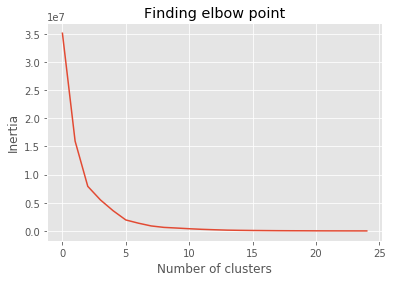

In [161]:
# features selection and formation
df_rent_filtered['distance'] = df_rent_filtered[['distance_n1', 'distance_n2', 'distance_n3','distance_n4','distance_n5']].min(axis = 1)
df_rent_filtered['bath'] = df_rent_filtered[['baths_full', 'baths']].min(axis = 1)
df_rent_filtered['equip'] = df_rent_filtered['bath'] + df_rent_filtered['beds']
column_list = ['distance', 'price', 'equip'] # used features!
# forming a new dataframe containing main features of properties
df_learn = df_rent_filtered[column_list]
# importing libraries
from sklearn.cluster import KMeans
kmeans_intertia = []
for kk in range(2, 3*3*3):
    kmeans = KMeans(n_clusters=kk, random_state=0).fit(df_learn)
    kmeans_intertia.append(kmeans.inertia_)
# plotting interia to find elbow point
kmeans_intertia = pd.DataFrame(kmeans_intertia)
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
kmeans_intertia.plot(kind = 'line', legend=None)
plt.title('Finding elbow point')
plt.ylabel('Inertia')
plt.xlabel('Number of clusters')
plt.show()

In [162]:
# deciding the number of clusters
kclusters = 7
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_learn)
# check cluster labels generated for each row in the dataframe
print('The 10 first properties clustring is ', kmeans.labels_[0:10])
df_rent_filtered['Cluster Labels'] = kmeans.labels_
df_rent_filtered.sort_values(['Cluster Labels', 'price', 'beds', 'bath'], ascending=[1, 1, 1, 1], inplace=True)
df_rent_filtered.reset_index(inplace = True, drop = True)
print_column = ['Cluster Labels','price', 'beds', 'bath', 'distance','address.line', 'address.lat', 'address.lon', 'address.line']
file_name_3 = r'output.csv'
path = os.path.dirname(os.path.abspath('Recommending rental properties.ipynb'))
df_rent_filtered[print_column].to_csv(os.path.join(path, file_name_3))
df_rent_filtered[print_column]

The 10 first properties clustring is  [0 0 0 0 0 0 0 5 3 3]


,Cluster Labels,price,beds,bath,distance,address.line,address.lat,address.lon,address.line
0,0,1695.0,0,1.0,1.262326,856 Beacon St,42.347276,-71.104035,856 Beacon St
1,0,2000.0,1,1.0,1.419777,94 Pearl St,42.362262,-71.105042,94 Pearl St
2,0,2000.0,2,1.0,2.759420,36 Mozart St,42.321511,-71.104501,36 Mozart St
3,0,2050.0,1,1.0,2.949377,10 Sumner Rd,42.376035,-71.112334,10 Sumner Rd
4,0,2200.0,1,1.0,2.491432,147 W 8th St Unit 147,42.334595,-71.053620,147 W 8th St Unit 147
5,0,2250.0,1,1.0,0.586108,274 Marlborough St # #ph,42.351547,-71.082650,274 Marlborough St # #ph
6,0,2350.0,2,1.0,2.590577,5 Badger Pl Unit 1,42.378234,-71.062758,5 Badger Pl Unit 1
7,1,6800.0,2,1.0,0.411751,87 MT Vernon Unit Carriageh,42.358455,-71.067997,87 MT Vernon Unit Carriageh
8,1,6995.0,5,2.0,1.855454,158 Western Ave,42.364736,-71.109149,158 Western Ave
9,1,7500.0,2,2.0,0.582007,149 West Newton St,42.342501,-71.077431,149 West Newton St


In [163]:
# importing libraries
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[center_lat, center_lon], width=800, height=600)
map_clusters.fit_bounds([[lat_min, lon_min], [lat_max, lon_max]])

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, price, bed, bath, cluster in zip(df_rent_filtered['address.lat'], df_rent_filtered['address.lon'], df_rent_filtered['price'], df_rent_filtered['beds'], df_rent_filtered['bath'], df_rent_filtered['Cluster Labels']):
    if ~np.isnan(cluster):
        cluster = int(cluster)
        label = folium.Popup( 'Cluster:' + str(cluster) + ', Price:' + str(price) + ', Bed:' + str(bed) + ', Bath:' + str(int(bath)), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

for lat, lng, label in zip(df_selected_neighbourhood['latitude'], df_selected_neighbourhood['longitude'], df_selected_neighbourhood['neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)
label = folium.Popup('Campus', parse_html=True)
folium.CircleMarker(
    campus_loc,
    radius=10,
    popup=label,
    color='red',
    fill=True,
    fill_color='#cc4331',
    fill_opacity=0.7,
    parse_html=False).add_to(map_clusters)

map_clusters

# END of CODE
Please send your inquiries to aron.shirazi (at) gmail.com